Introduction:
Cardiovascular diseases (CVDs) are the leading cause of death globally, and early detection is paramount in improving patient outcomes. Leveraging a comprehensive dataset from Kaggle, this project aims to employ machine learning techniques to predict the likelihood of an individual having cardiovascular disease based on various health metrics. Through rigorous exploratory data analysis, model selection, and validation, we strive to build a reliable and interpretable model that can aid in early diagnosis and facilitate more timely interventions for those at risk.

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
import os

In [167]:
data = pd.read_csv('C:/ReqDocs/CVD_cleaned.csv')

In [168]:
data.rename(columns={'Alcohol_Consumption': 'Alcohol_Consumption_perMonth'},inplace = True)
data.rename(columns={'Fruit_Consumption': 'Fruit_Consumption_perMonth'},inplace = True)
data.rename(columns={'Green_Vegetables_Consumption': 'Green_Vegetables_Consumption_perMonth'},inplace = True)
data.rename(columns={'FriedPotato_Consumption': 'FriedPotato_Consumption_perMonth'},inplace = True)

In [169]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   General_Health                         308854 non-null  object 
 1   Checkup                                308854 non-null  object 
 2   Exercise                               308854 non-null  object 
 3   Heart_Disease                          308854 non-null  object 
 4   Skin_Cancer                            308854 non-null  object 
 5   Other_Cancer                           308854 non-null  object 
 6   Depression                             308854 non-null  object 
 7   Diabetes                               308854 non-null  object 
 8   Arthritis                              308854 non-null  object 
 9   Sex                                    308854 non-null  object 
 10  Age_Category                           308854 non-null  

We must first clean the data. Although this data set already seems to be cleaned, it is still good practice to show this step:

In [170]:
# Checking for missing values in each column
missing_values = data.isnull().sum()
print("Number of missing values for each column:")
print(missing_values)

# Total missing values in the dataset
total_missing = missing_values.sum()
print(f"\nTotal missing values in the dataset: {total_missing}")



Number of missing values for each column:
General_Health                           0
Checkup                                  0
Exercise                                 0
Heart_Disease                            0
Skin_Cancer                              0
Other_Cancer                             0
Depression                               0
Diabetes                                 0
Arthritis                                0
Sex                                      0
Age_Category                             0
Height_(cm)                              0
Weight_(kg)                              0
BMI                                      0
Smoking_History                          0
Alcohol_Consumption_perMonth             0
Fruit_Consumption_perMonth               0
Green_Vegetables_Consumption_perMonth    0
FriedPotato_Consumption_perMonth         0
dtype: int64

Total missing values in the dataset: 0


It can be seen that there are zero null values in each column, so we procede to checking to see if we need to convert any data types

In [171]:
# 1. Convert data types if necessary
for column in data.select_dtypes(include=['object']).columns:
    print(f"{column} unique values: {data[column].unique()}")

# 2. Handling outliers for float columns
numeric_data = data.select_dtypes(include=['float64'])

Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Only filter rows based on numeric columns
filtered_entries = ~((numeric_data < lower_bound) | (numeric_data > upper_bound)).any(axis=1)
data = data[filtered_entries]

# 3. Encoding Categorical Variables
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le  # Storing the encoder for potential inverse transformations later



General_Health unique values: ['Poor' 'Very Good' 'Good' 'Fair' 'Excellent']
Checkup unique values: ['Within the past 2 years' 'Within the past year' '5 or more years ago'
 'Within the past 5 years' 'Never']
Exercise unique values: ['No' 'Yes']
Heart_Disease unique values: ['No' 'Yes']
Skin_Cancer unique values: ['No' 'Yes']
Other_Cancer unique values: ['No' 'Yes']
Depression unique values: ['No' 'Yes']
Diabetes unique values: ['No' 'Yes' 'No, pre-diabetes or borderline diabetes'
 'Yes, but female told only during pregnancy']
Arthritis unique values: ['Yes' 'No']
Sex unique values: ['Female' 'Male']
Age_Category unique values: ['70-74' '60-64' '75-79' '80+' '65-69' '50-54' '45-49' '18-24' '30-34'
 '55-59' '35-39' '40-44' '25-29']
Smoking_History unique values: ['Yes' 'No']


Distribution of Numeric Features
Visualizing the distributions of numeric features can provide insights into their spread and potential outliers
Below I will show the number of individuals in each subset of each feature..

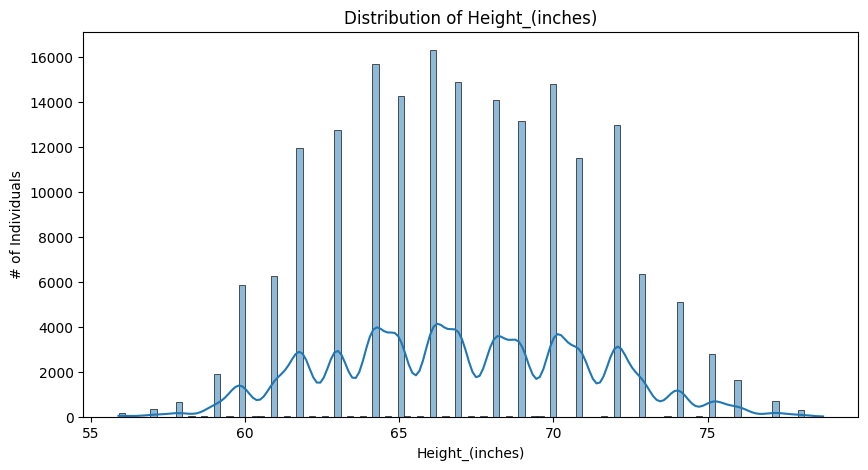

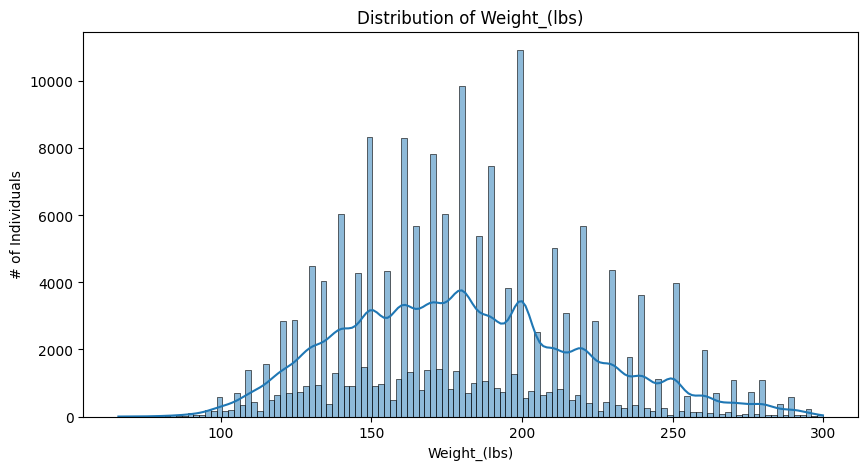

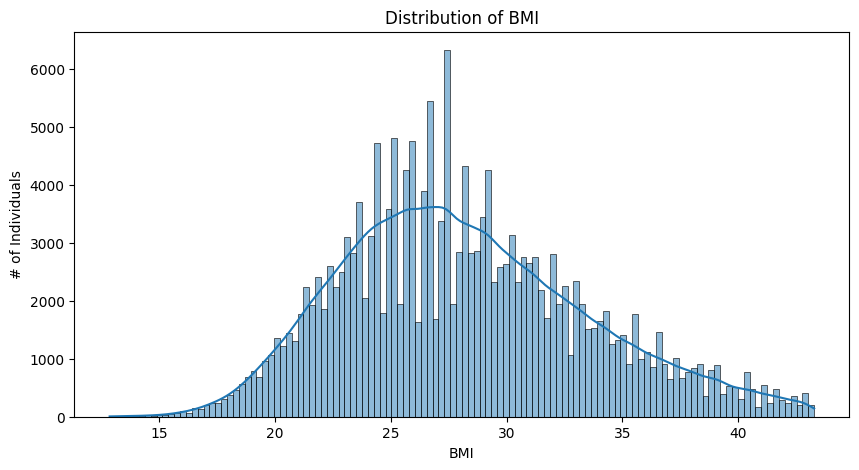

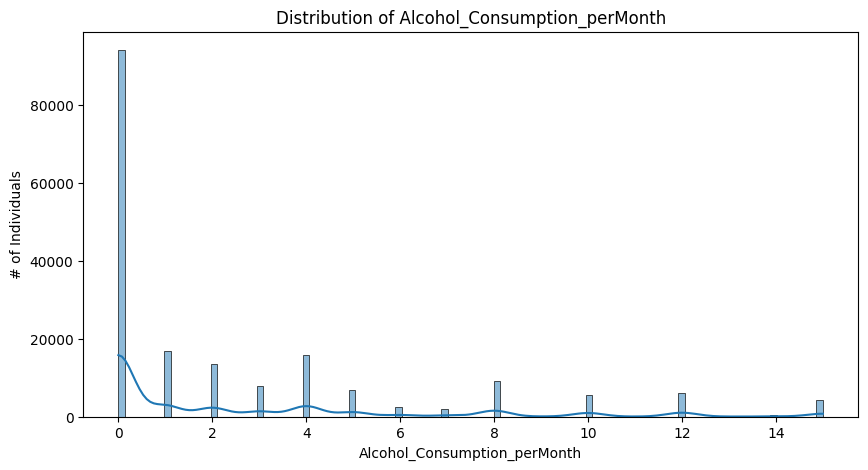

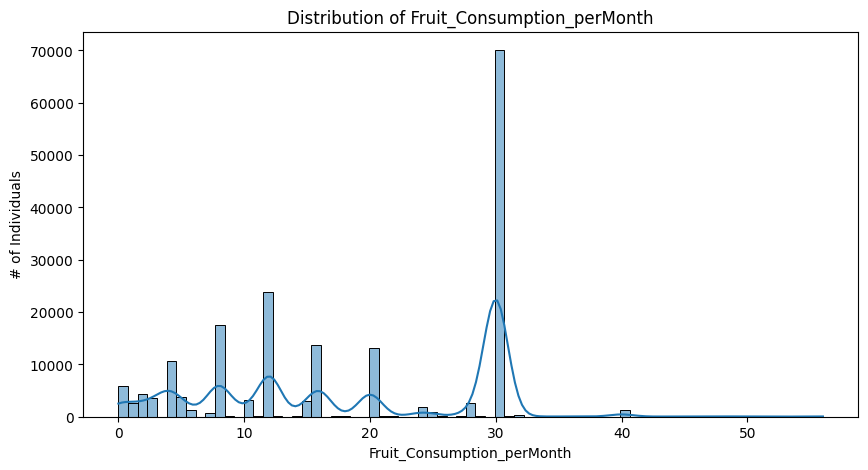

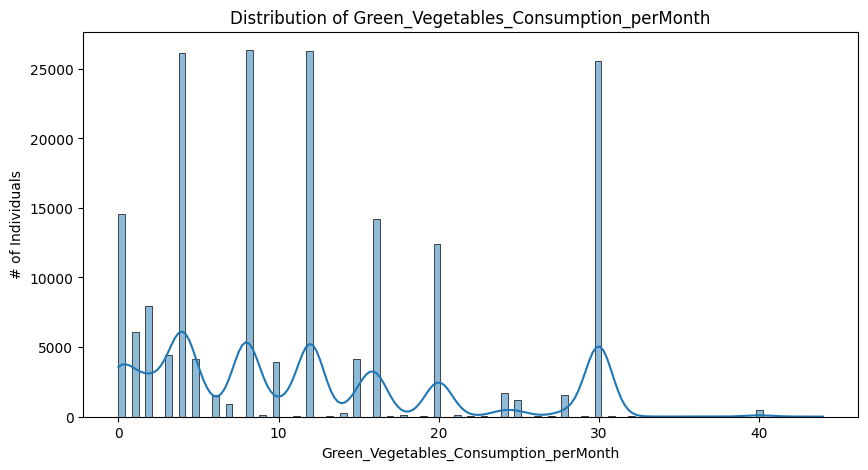

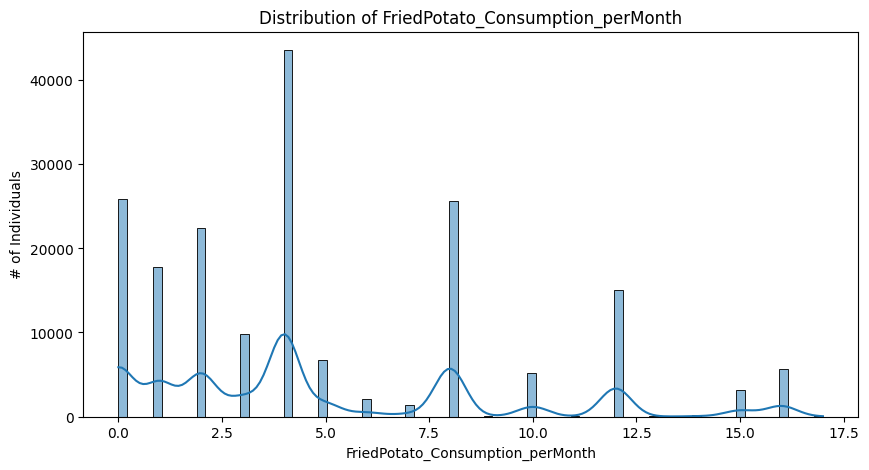

In [172]:
# Convert Height and Weight
data['Height_(inches)'] = data['Height_(cm)'] / 2.54
data['Weight_(lbs)'] = data['Weight_(kg)'] * 2.20462

numeric_features = ['Height_(inches)', 'Weight_(lbs)', 'BMI', 'Alcohol_Consumption_perMonth', 
                    'Fruit_Consumption_perMonth', 'Green_Vegetables_Consumption_perMonth', 'FriedPotato_Consumption_perMonth']

for feature in numeric_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('# of Individuals')
    plt.show()


Let's now show the categorical features.

['Very Good' 'Excellent' 'Good' 'Fair' 'Poor']
['70-74' '60-64' '75-79' '80+' '65-69' '50-54' '45-49' '30-34' '55-59'
 '18-24' '35-39' '40-44' '25-29']
['Within the past 5 years' 'Within the past year' 'Never'
 'Within the past 2 years' '5 or more years ago']


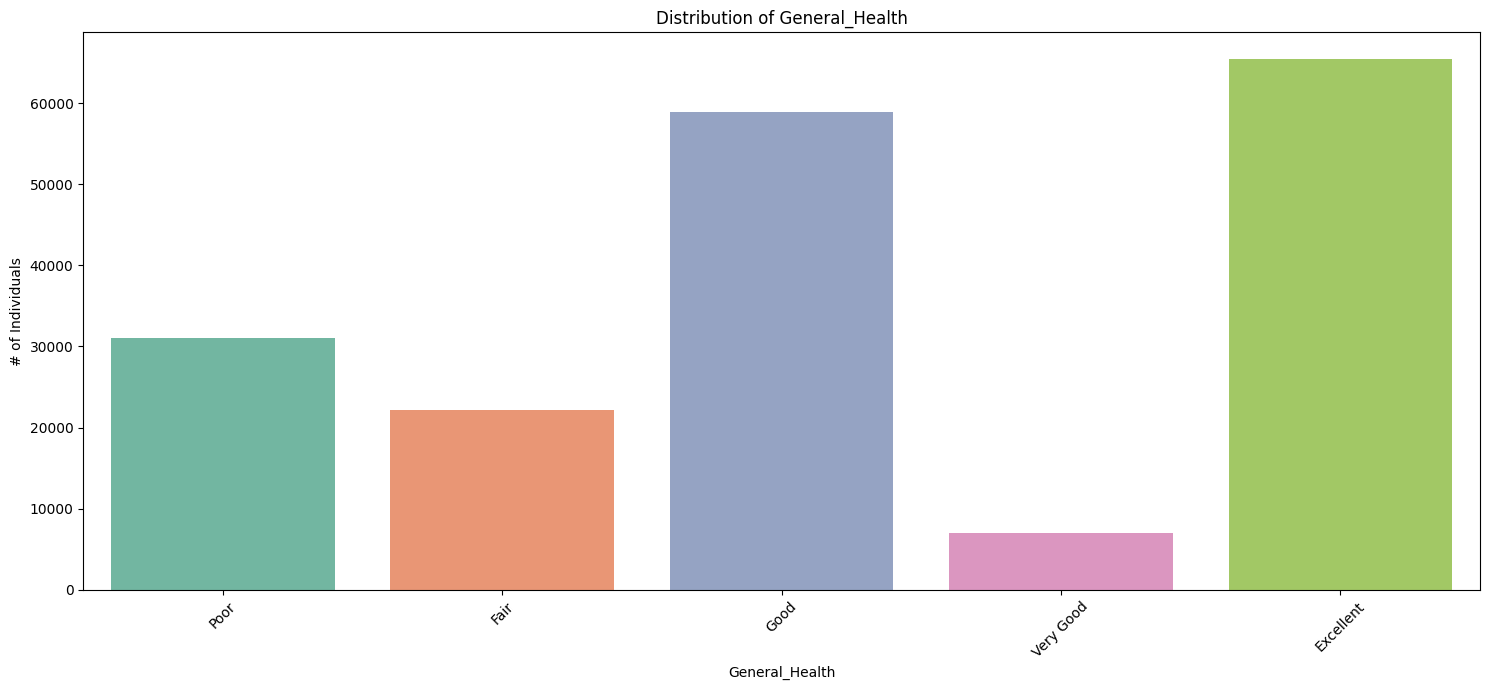

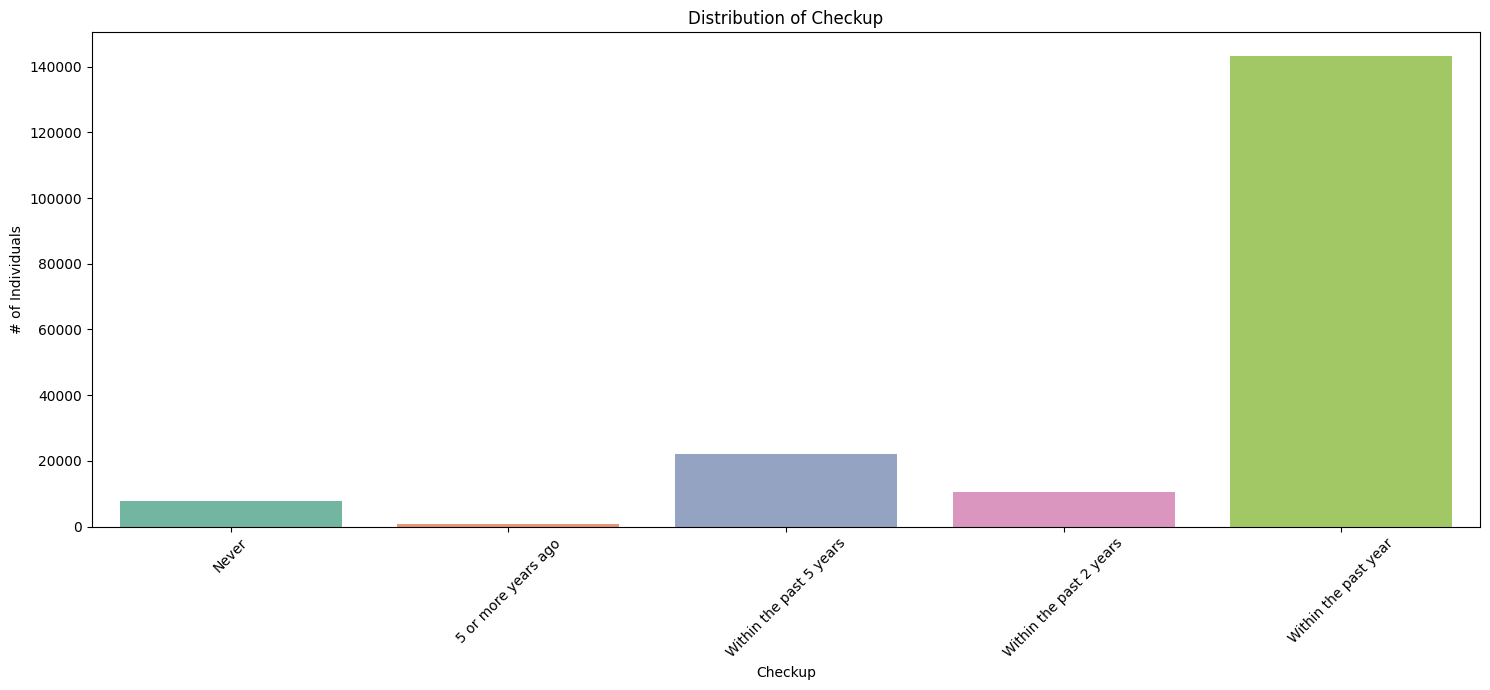

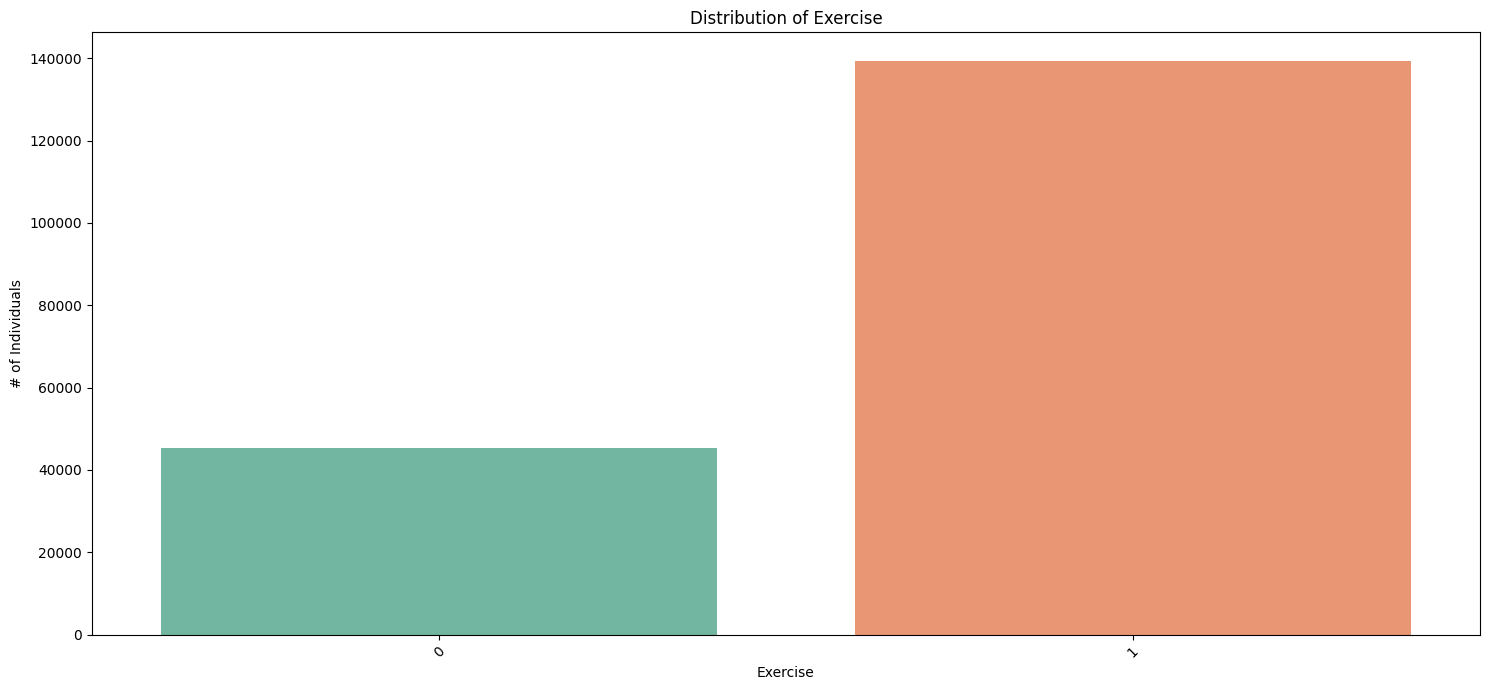

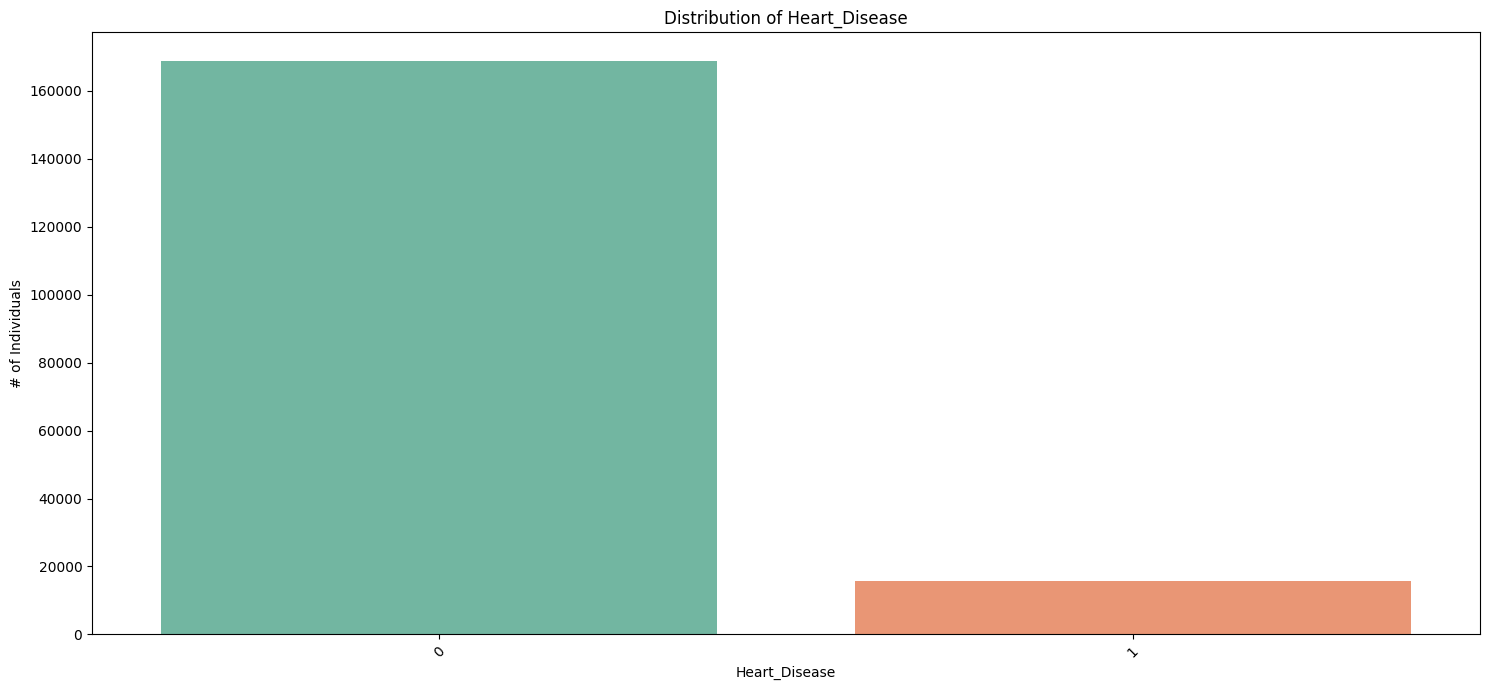

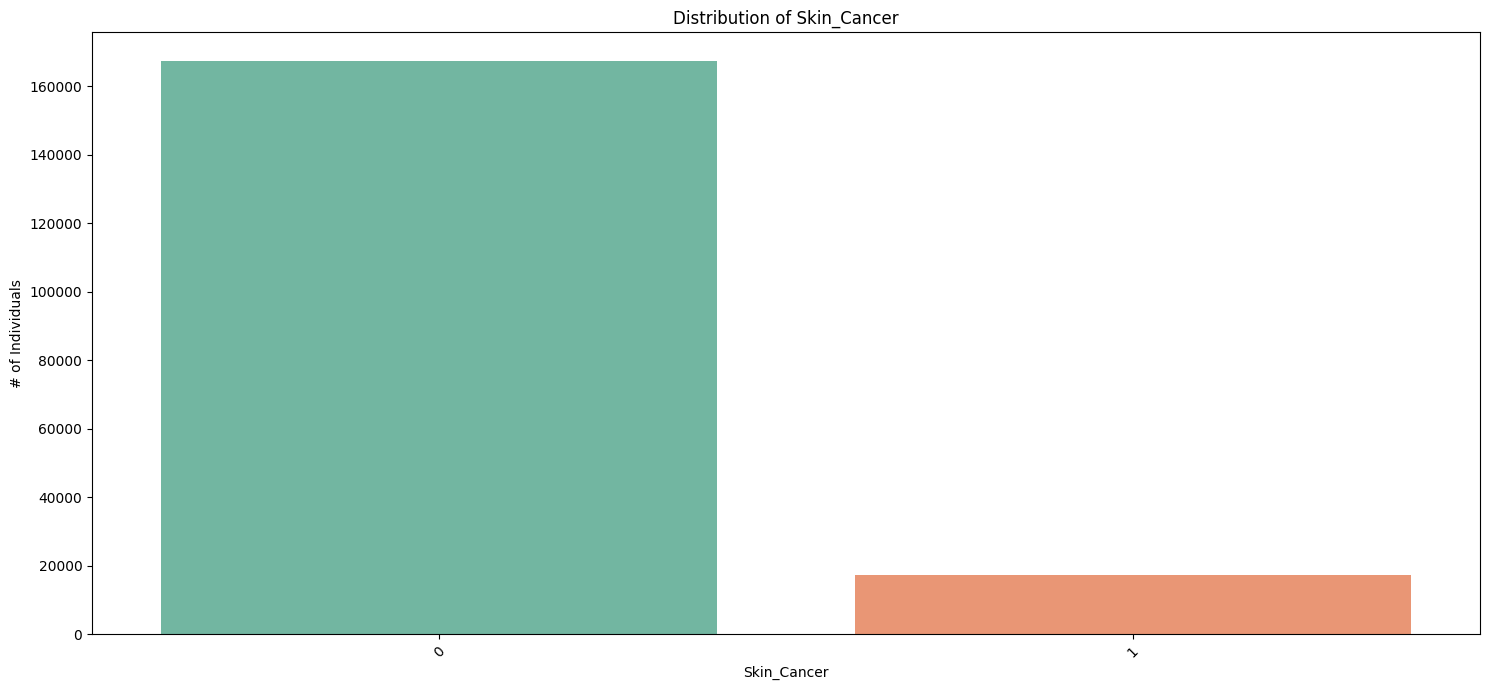

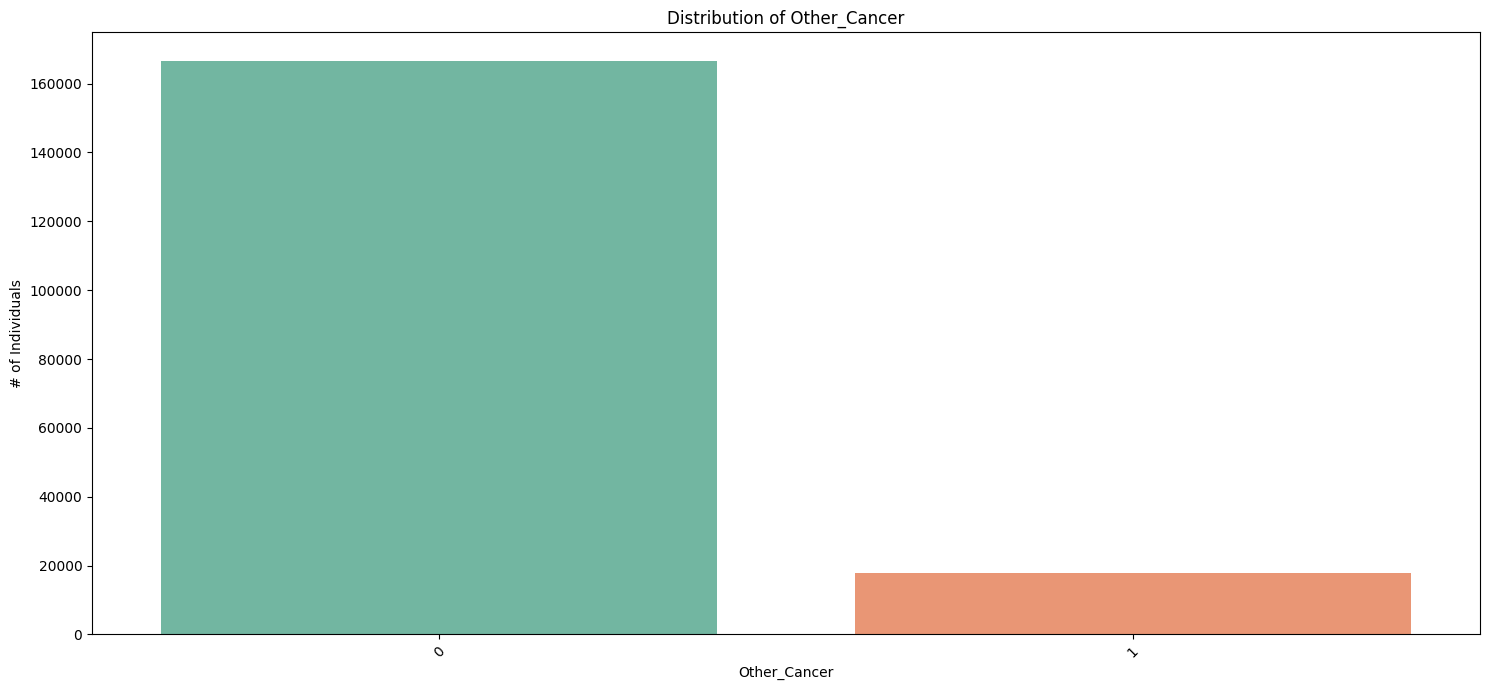

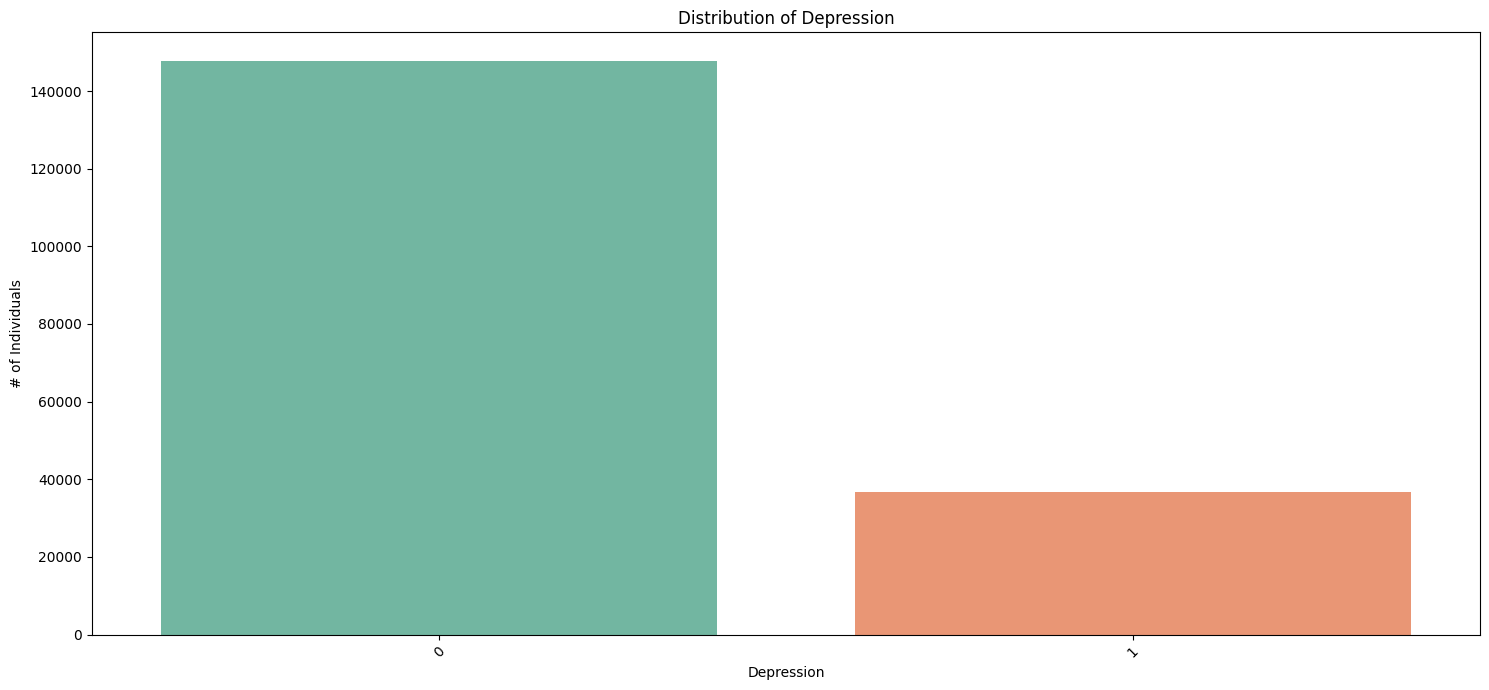

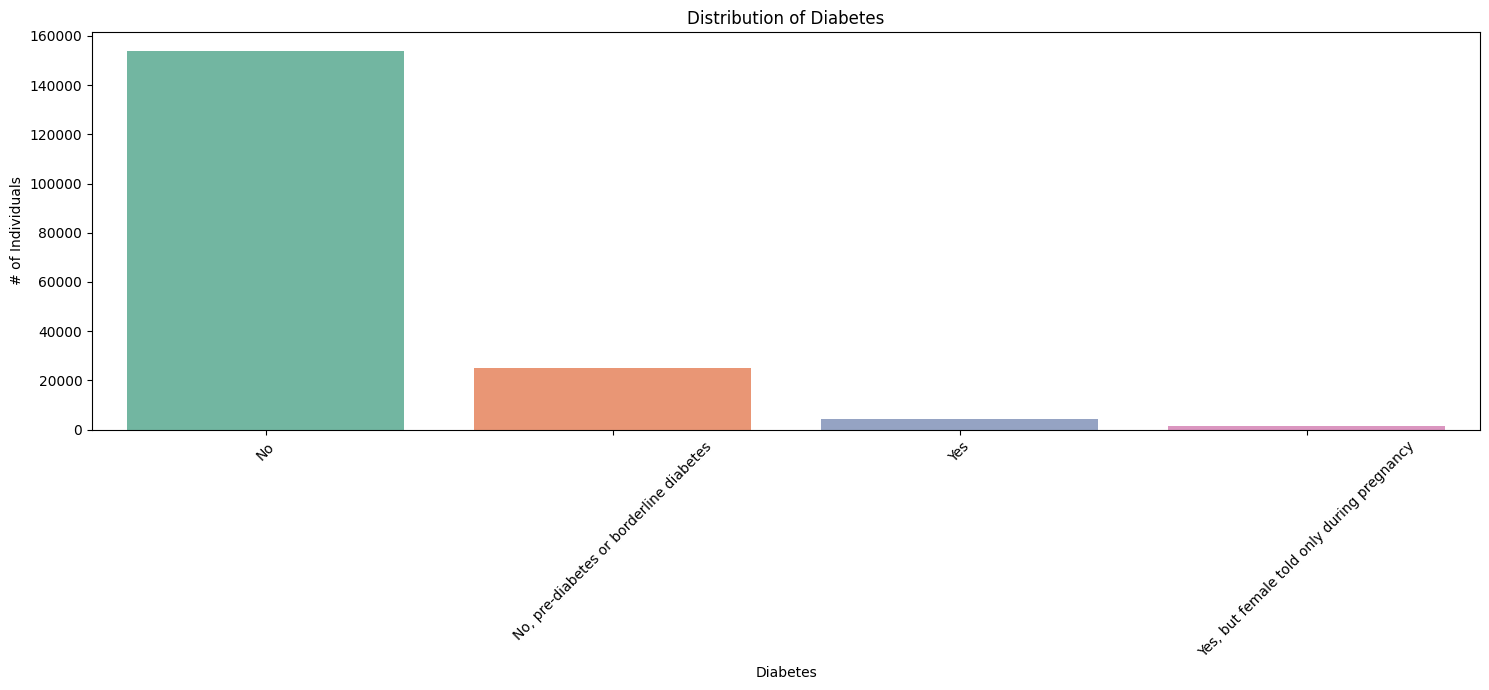

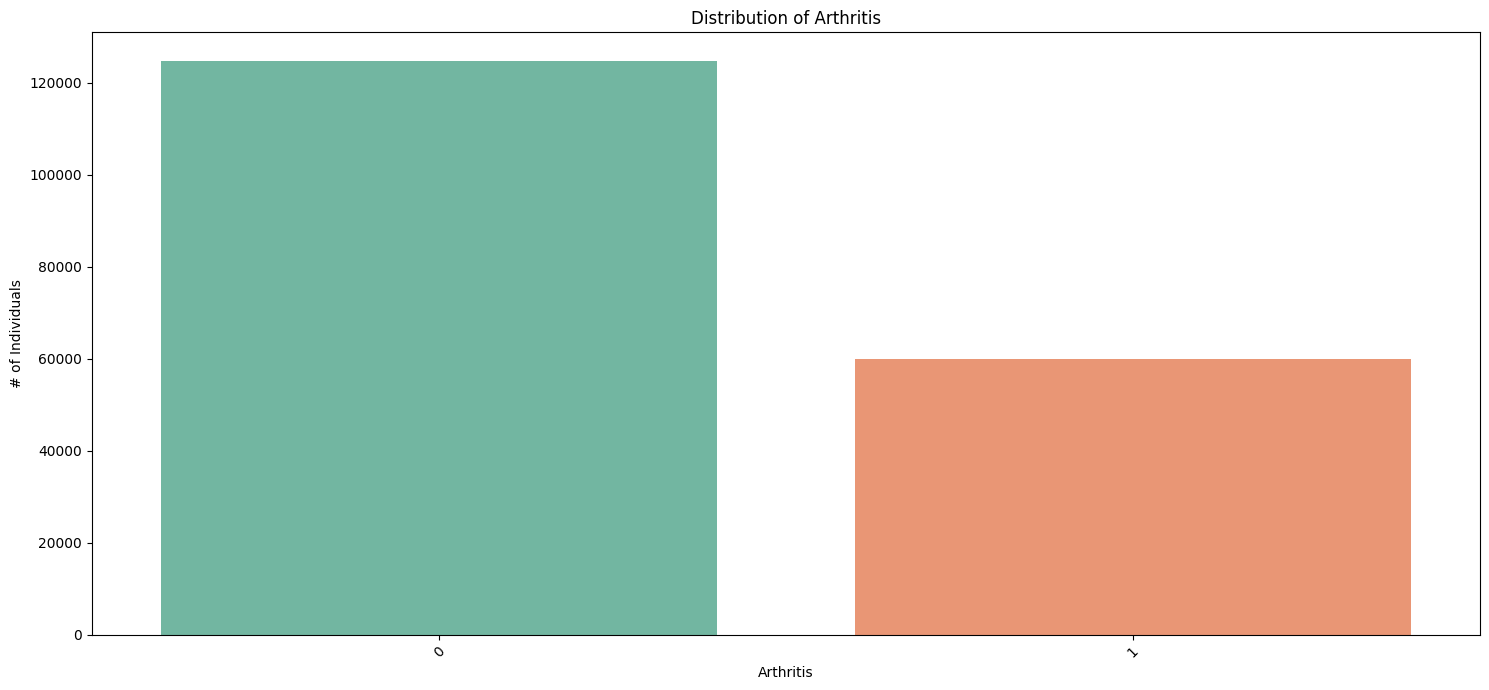

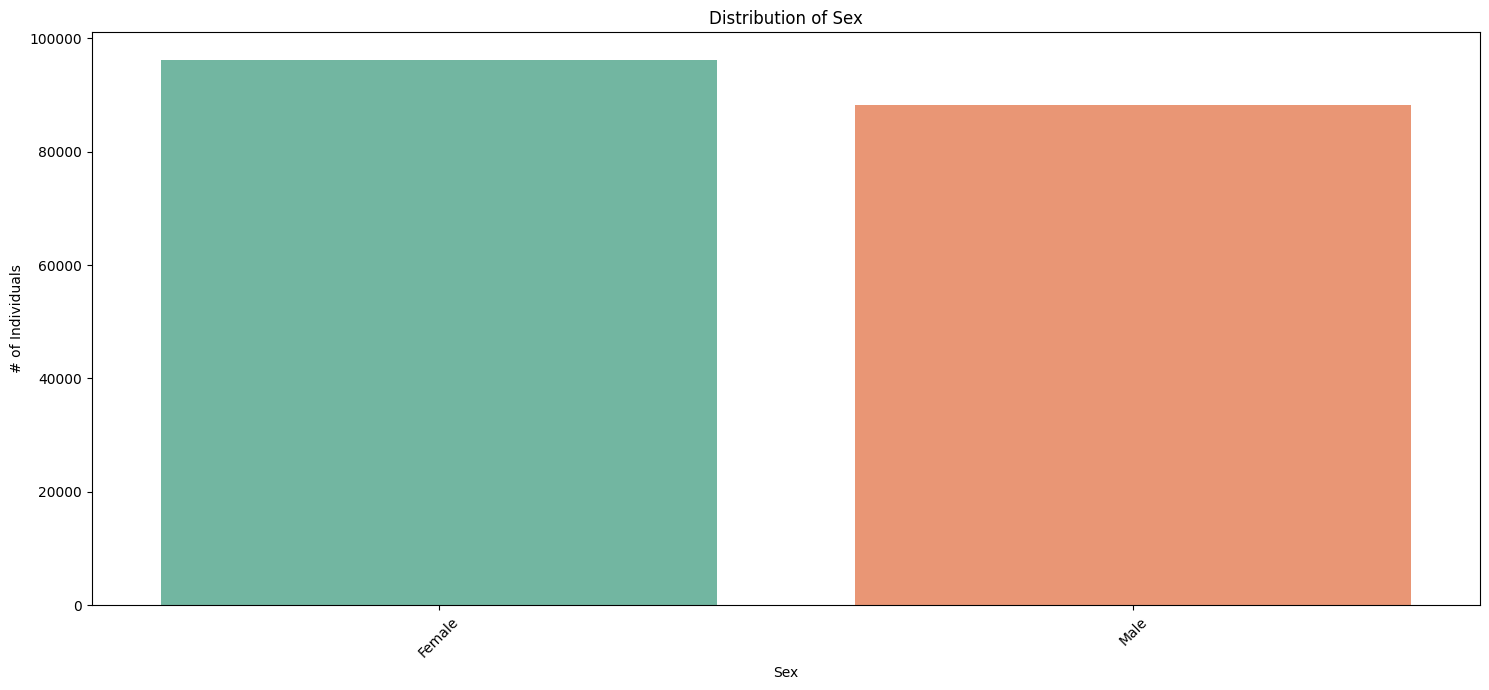

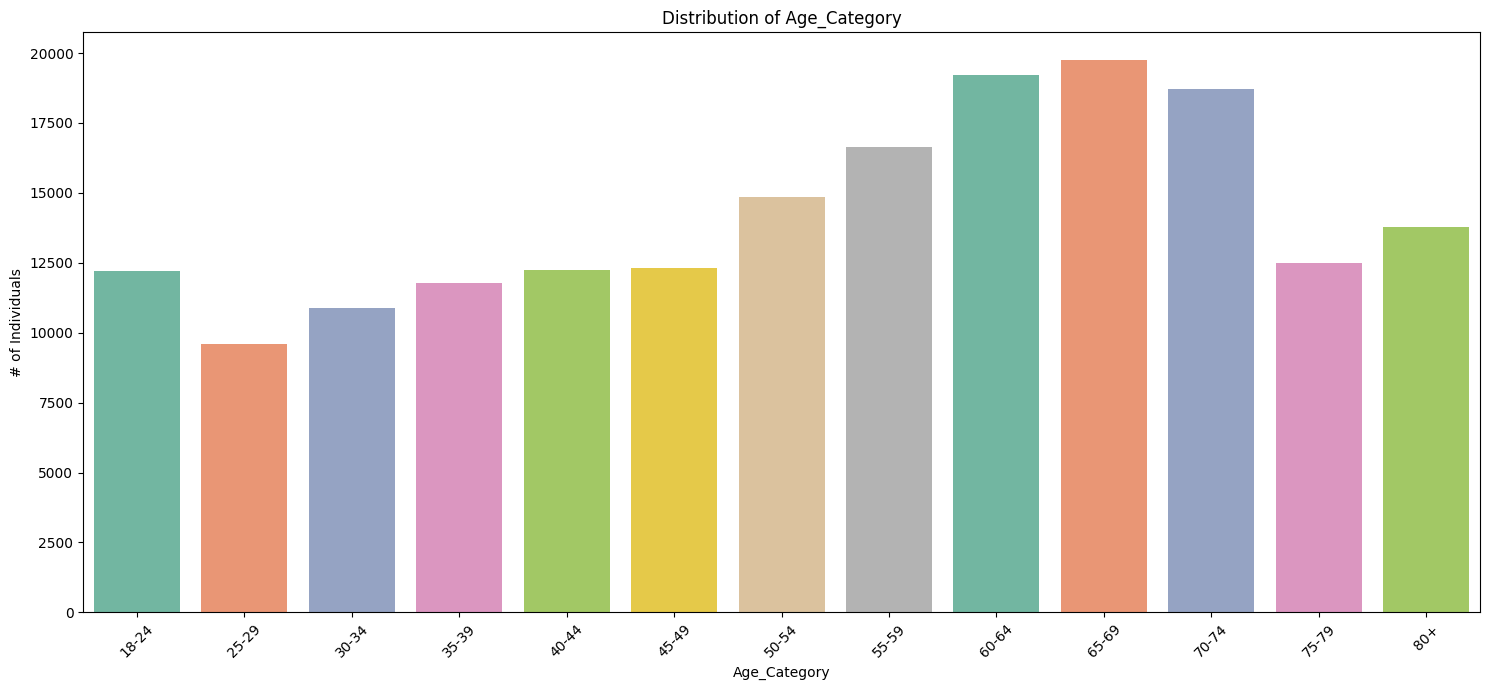

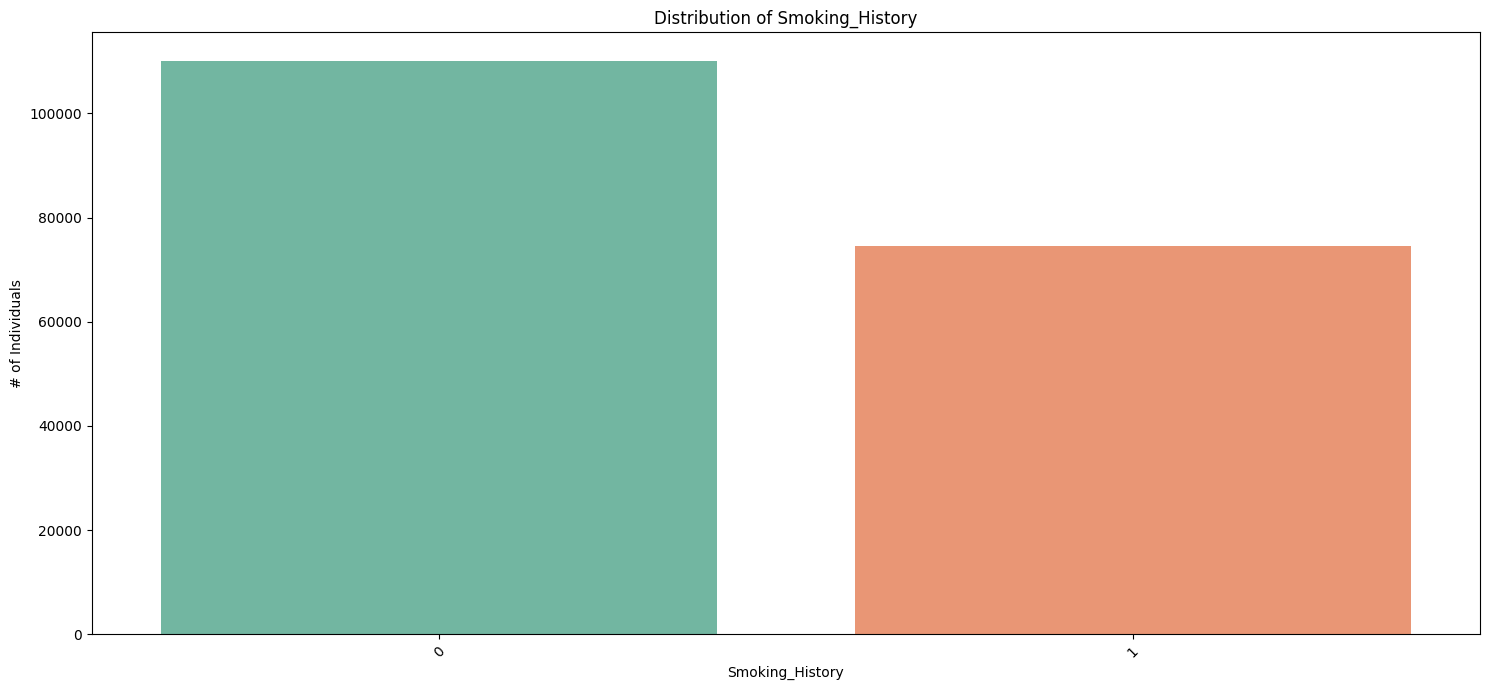

In [173]:
# Mapping for General_Health
health_mapping = {
    0: 'Poor',
    1: 'Fair',
    2: 'Good',
    3: 'Very Good',
    4: 'Excellent'
}

# Mapping for Age_Category
age_mapping = {
    0: '18-24',
    1: '25-29',
    2: '30-34',
    3: '35-39',
    4: '40-44',
    5: '45-49',
    6: '50-54',
    7: '55-59',
    8: '60-64',
    9: '65-69',
    10: '70-74',
    11: '75-79',
    12: '80+'
}

# Mapping for Checkup
checkup_mapping = {
    0: 'Never',
    1: '5 or more years ago',
    2: 'Within the past 5 years',
    3: 'Within the past 2 years',
    4: 'Within the past year'
}

# Mapping for diabetes
diabetes_mapping = {
    0 : 'No',
    1 : 'Yes',
    2 : 'No, pre-diabetes or borderline diabetes',
    3 : 'Yes, but female told only during pregnancy'
}

#Mapping for sex
sex_mapping = {
    0 : 'Female',
    1 : 'Male'
}

# Convert the integer values to their corresponding string values
data['General_Health'] = data['General_Health'].map(health_mapping)
data['Age_Category'] = data['Age_Category'].map(age_mapping)
data['Checkup'] = data['Checkup'].map(checkup_mapping)
data['Diabetes'] = data['Diabetes'].map(diabetes_mapping)
data['Sex'] = data['Sex'].map(sex_mapping)

# Check the unique values again to confirm the transformation
print(data['General_Health'].unique())
print(data['Age_Category'].unique())
print(data['Checkup'].unique())

# Define the order for ordinal features
order_general_health = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
order_checkup = ['Never', '5 or more years ago', 'Within the past 5 years', 
                 'Within the past 2 years', 'Within the past year']
order_age_category = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', 
                      '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
order_diabetes = ['No','Yes','No, pre-diabetes or borderline diabetes','Yes, but female told only during pregnancy']
order_sex = ['Female','Male']

orders = {
    'General_Health': order_general_health,
    'Checkup': order_checkup,
    'Age_Category': order_age_category
}

# Plot each feature
categorical_features = ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                        'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']

for feature in categorical_features:
    plt.figure(figsize=(15, 7))
    
    # Use the predefined order
    category_order = orders.get(feature)
    
    sns.countplot(data=data, x=feature, palette="Set2", order=category_order)
    plt.title(f'Distribution of {feature}')
    plt.ylabel('# of Individuals')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




Now to create the model

First, we need to reverse the mapping done in the previous step

In [174]:
# Reverse the mappings
reverse_health_mapping = {v: k for k, v in health_mapping.items()}
reverse_age_mapping = {v: k for k, v in age_mapping.items()}
reverse_checkup_mapping = {v: k for k, v in checkup_mapping.items()}
reverse_diabetes_mapping = {v: k for k, v in diabetes_mapping.items()}
reverse_sex_mapping = {v: k for k, v in sex_mapping.items()}

# Convert the string values back to their original integer values
data['General_Health'] = data['General_Health'].map(reverse_health_mapping)
data['Age_Category'] = data['Age_Category'].map(reverse_age_mapping)
data['Checkup'] = data['Checkup'].map(reverse_checkup_mapping)
data['Diabetes'] = data['Diabetes'].map(reverse_diabetes_mapping)
data['Sex'] = data['Sex'].map(reverse_sex_mapping)

# Check the data types again to confirm the transformation
print(data['General_Health'].unique())
print(data['Age_Category'].unique())
print(data['Checkup'].unique())
print(data['Diabetes'].unique())
print(data['Sex'].unique())

data.info()


[3 4 2 1 0]
[10  8 11 12  9  6  5  2  7  0  3  4  1]
[2 4 0 3 1]
[0 2 1 3]
[0 1]
<class 'pandas.core.frame.DataFrame'>
Index: 184533 entries, 0 to 308853
Data columns (total 21 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   General_Health                         184533 non-null  int64  
 1   Checkup                                184533 non-null  int64  
 2   Exercise                               184533 non-null  int32  
 3   Heart_Disease                          184533 non-null  int32  
 4   Skin_Cancer                            184533 non-null  int32  
 5   Other_Cancer                           184533 non-null  int32  
 6   Depression                             184533 non-null  int32  
 7   Diabetes                               184533 non-null  int64  
 8   Arthritis                              184533 non-null  int32  
 9   Sex                                    184533 non

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE  # Make sure to install this package if you haven't

# 1. Identify features (X) and target (y)
X = data.drop(columns=['Heart_Disease'])  # Remove the target column
y = data['Heart_Disease']

# 2. Address Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# 3. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Initialize and fit the model
logistic_model = LogisticRegression()

logistic_model.fit(X_train_scaled, y_train)

# 6. Model Predictions
y_pred_train = logistic_model.predict(X_train_scaled)
y_pred_test = logistic_model.predict(X_test_scaled)

# 7. Model Evaluation
print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))



Training Accuracy: 0.7580974807837562
Test Accuracy: 0.7613814756671899

Confusion Matrix:
 [[24780  9021]
 [ 7091 26630]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75     33801
           1       0.75      0.79      0.77     33721

    accuracy                           0.76     67522
   macro avg       0.76      0.76      0.76     67522
weighted avg       0.76      0.76      0.76     67522



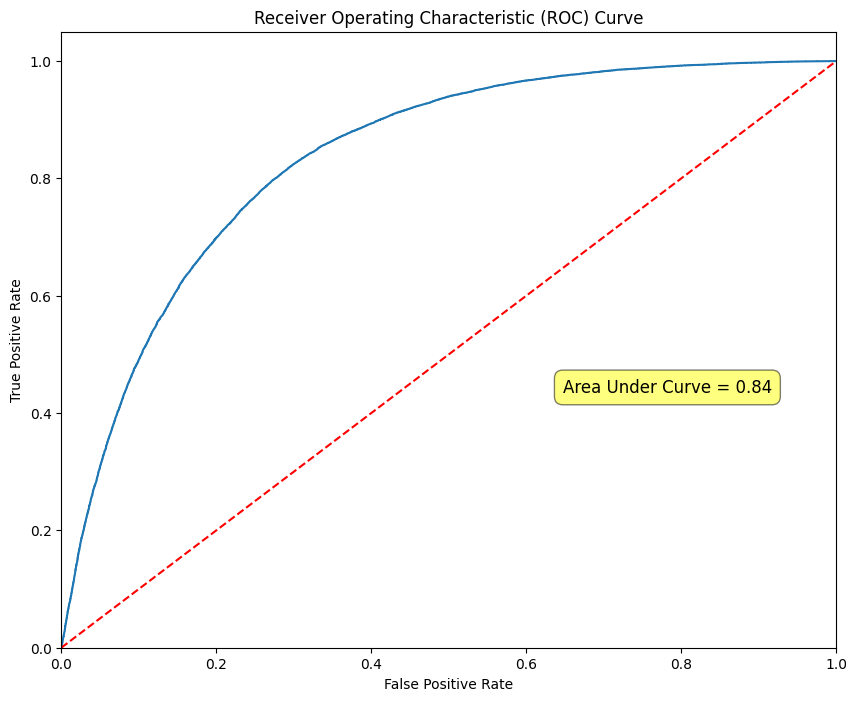

In [184]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get the probability scores for the positive class
y_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.annotate(f'Area Under Curve = {auc:.2f}', xy=(0.8, 0.4), xytext=(-10, 10),
             xycoords='axes fraction', textcoords='offset points',
             size=12, ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
plt.show()


Feature                             Coefficient    
Age_Category                        1.1273974687130917
Checkup                             0.2059046727264193
Diabetes                            0.12586501723692728
Height_(inches)                     0.08089097843889127
Height_(cm)                         0.08089097843888919
Weight_(kg)                         0.0806679642622856
Weight_(lbs)                        0.08066796426228354
Sex                                 0.031583647881366854
Green_Vegetables_Consumption_perMonth -0.008243736012948635
BMI                                 -0.01825339638157263
Fruit_Consumption_perMonth          -0.03586010823660796
FriedPotato_Consumption_perMonth    -0.04021733385382881
Smoking_History                     -0.07174478647717608
Arthritis                           -0.1192414604984934
Alcohol_Consumption_perMonth        -0.16521519547136504
Depression                          -0.22222461015935038
Other_Cancer                        -0.26055

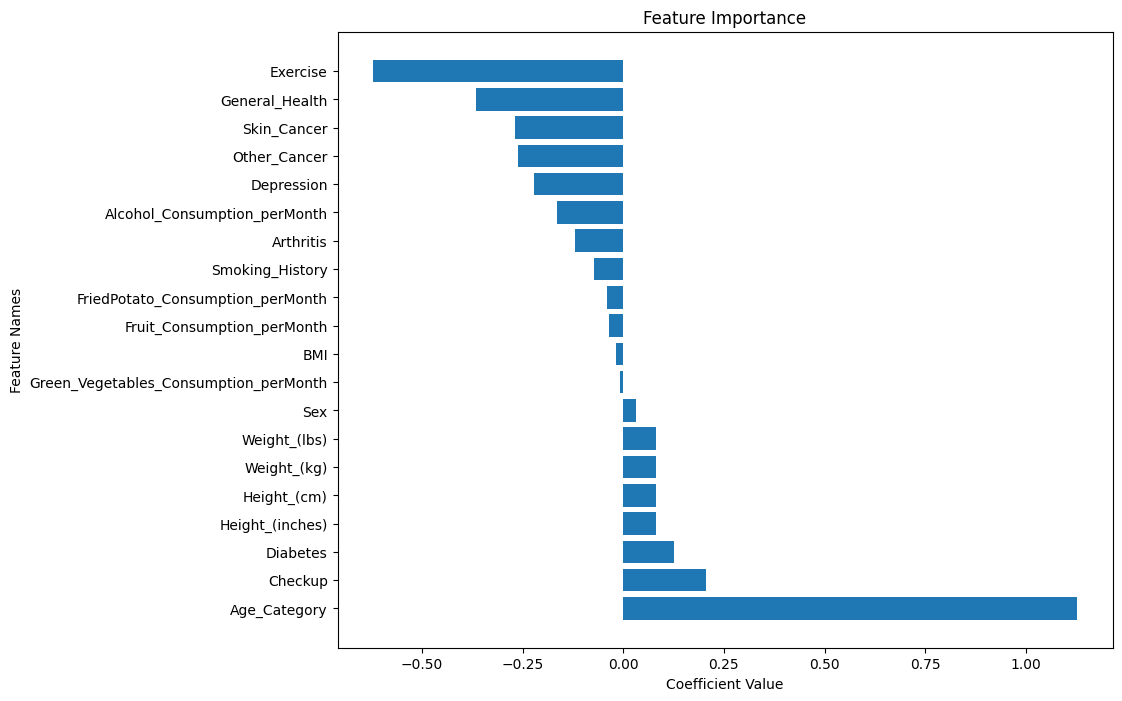

In [187]:
# Get the coefficients of the logistic regression model
coefficients = logistic_model.coef_[0]
features = X_train.columns
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort the DataFrame by the coefficients
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

print("{:<35} {:<15}".format("Feature", "Coefficient"))
print("="*50)

for index, row in feature_importance.iterrows():
    print("{:<35} {:<15}".format(row['Feature'], row['Coefficient']))
    
# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Names')
plt.title('Feature Importance')
plt.show()

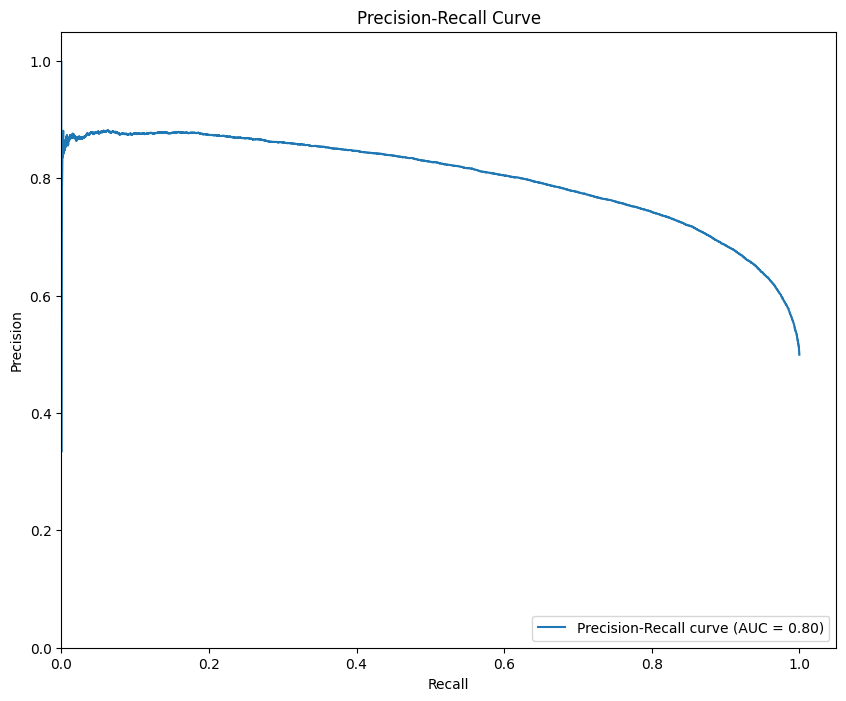

In [186]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import average_precision_score

# Get prediction probabilities
y_scores = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calculate Precision, Recall, and Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Compute Area Under Curve (AUC)
area = auc(recall, precision)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {area:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.show()



Conclusion
The logistic regression model developed to predict heart disease has a training accuracy of 75.8% and a test accuracy of 76.1%. Although these numbers suggest that the model is relatively accurate, additional metrics such as Precision, Recall, and the ROC curve should also be considered for a more comprehensive evaluation, especially given that heart disease prediction is a critical healthcare application where the stakes are high.

Feature Importance
The model shows that 'Age_Category' is the most influential factor in predicting heart disease, with a coefficient of approximately 1.13. This implies that as the age category increases, the odds of having heart disease also significantly increase.

Conversely, 'Exercise' has the most negative impact with a coefficient of about -0.62, suggesting that increased exercise is associated with lower odds of heart disease. It's important to note that features such as 'Green_Vegetables_Consumption_perMonth' and 'BMI' have coefficients close to zero, indicating they might not be strong predictors in this model.

Interestingly, features related to lifestyle choices like 'Smoking_History' and 'Alcohol_Consumption_perMonth' have negative coefficients, which might appear counterintuitive. This could be due to correlations with other features or could be a point for further investigation.